In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import mutual_info_classif

### Introduction

The dataset contains information about the obesity classification of individuals. The data was collected from a variety of sources, including medical records, surveys, and self-reported data. The dataset includes the following columns:

- ID: A unique identifier for each individual
- Age: The age of the individual
- Gender: The gender of the individual
- Height: The height of the individual in centimeters
- Weight: The weight of the individual in kilograms
- BMI: The body mass index of the individual, calculated as weight divided by height squared
- Label: The obesity classification of the individual, which can be one of the following:
  - Normal Weight
  - Overweight
  - Obese
  - Underweight

### Problem Statement:


Objective of analysis:
    The objective of the analysis in the provided code is to build a decision tree classifier model to classify an individual into a weight class given the above attributes.
    

### Loading data

In [2]:
LABEL_MAPPING = {
    'Underweight': 0,
    'Normal Weight': 1,
    'Overweight': 2,
    'Obese': 3
}

FEATURES = ['Age', 'Gender', 'Height', 'Weight', 'BMI']
NUMERICAL_FEATURES = ['Age','Height', 'Weight', 'BMI']
RANDOM_STATE = 8

In [3]:
df = pd.read_csv("Obesity Classification.csv")
# df['Label'] = df['Label'].map(label_mapping)
df.head()

,ID,Age,Gender,Height,Weight,BMI,Label
0,1,25,Male,175,80,25.3,Normal Weight
1,2,30,Female,160,60,22.5,Normal Weight
2,3,35,Male,180,90,27.3,Overweight
3,4,40,Female,150,50,20.0,Underweight
4,5,45,Male,190,100,31.2,Obese


### Data Exploration

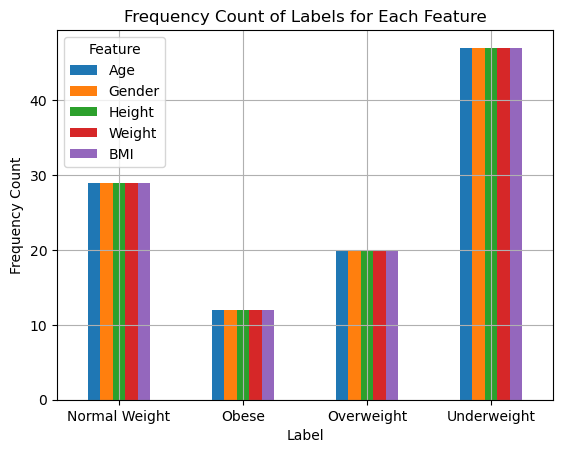

In [4]:
# Group by the 'Label' column and calculate the frequency count for each feature
grouped = df.loc[:, df.columns != 'ID'].groupby('Label').count()

# Plot the frequency count for each feature
ax = grouped.plot(kind='bar')

plt.xlabel('Label')
plt.ylabel('Frequency Count')
plt.title('Frequency Count of Labels for Each Feature')
plt.legend(title='Feature')
plt.xticks(rotation=0)
plt.grid()
plt.show()

From the above plot the dataset contains is not balanced with respect to labels . It contains more samples with Underweight label and few samples with obese label. Consequently these can affect model performance i.e models can do better in predicting the underweight class correctly compared to other classes and similarily models can perform poorly in correctly predicting Obese classifications

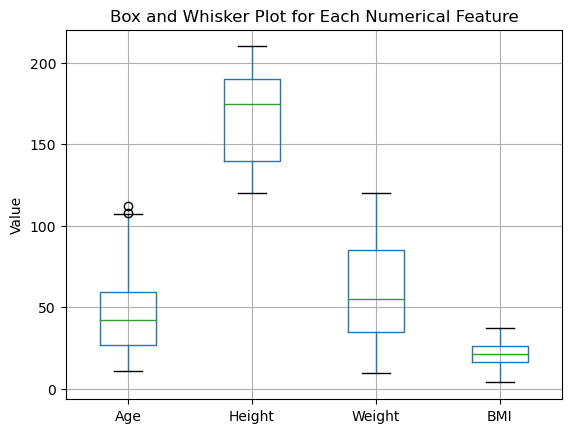

In [5]:
plt.figure()
df.boxplot(column = NUMERICAL_FEATURES)

plt.ylabel('Value')
plt.title('Box and Whisker Plot for Each Numerical Feature')
plt.xticks(rotation = 0)
plt.show()

From the above plot the BMI feature seemw to have the least variation compared to other features .

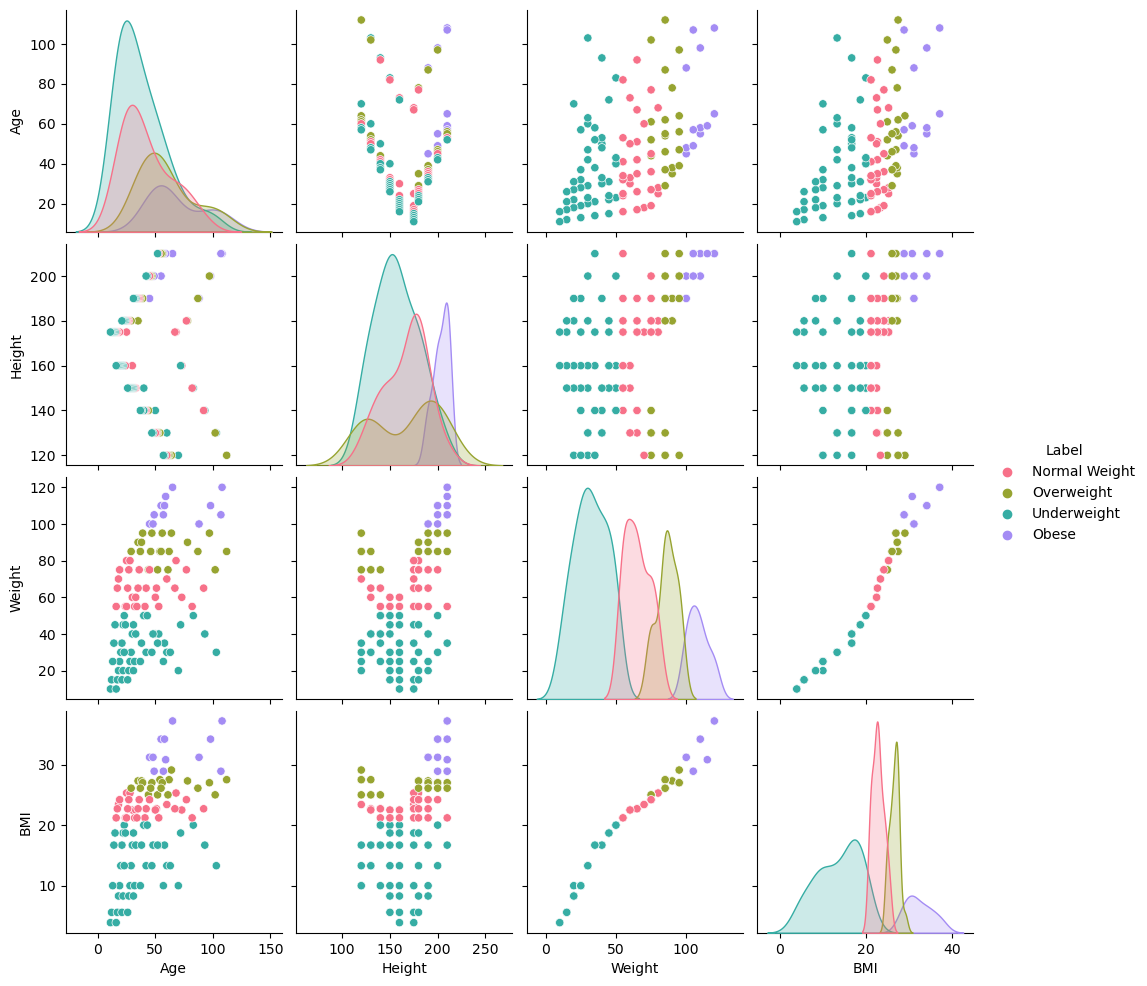

In [6]:
sns.pairplot(df.loc[:, df.columns != 'ID'],hue = 'Label',diag_kind = 'kde',kind = 'scatter',palette = 'husl')

From the above plot, there does seem to be a relationship between Age and Weight i.e as you age you tend to weigh more . 

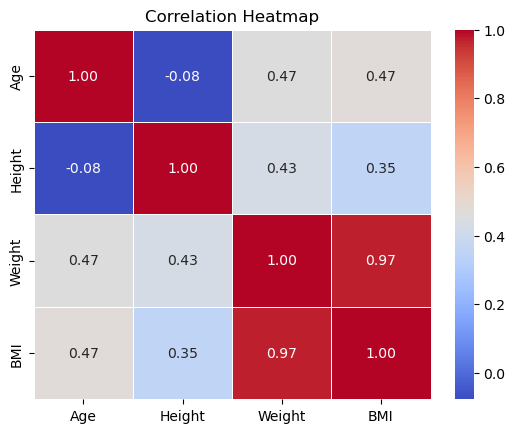

Summary of Correlation Findings:
             Age    Height    Weight       BMI
Age     1.000000 -0.076896  0.465106  0.474185
Height -0.076896  1.000000  0.428890  0.354340
Weight  0.465106  0.428890  1.000000  0.972829
BMI     0.474185  0.354340  0.972829  1.000000


In [7]:
# Calculate the correlation matrix
correlation_matrix = df[NUMERICAL_FEATURES].corr()

# Create a heatmap of the correlation matrix
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Summary of findings
print("Summary of Correlation Findings:")
print(correlation_matrix)

### Features

We use one hot encoding to transform the categorical feature Gender , label encoding is not preferred since this would introduces hierachy between the different feature instances which models may misinterpret i.e there is no sense of ordering for the feature. Feature scaling will not be performed since decision trees are not sensitive to feature scaling

In [8]:
MODEL_FEATURES = ['Age', 'Female', 'Male', 'Height', 'Weight', 'BMI']

In [9]:
x = (df.loc[: , ~df.columns.isin(['Gender' , 'ID'])]).copy()
x[['Female', 'Male']] = pd.get_dummies(df['Gender'])
x.head()

,Age,Height,Weight,BMI,Label,Female,Male
0,25,175,80,25.3,Normal Weight,0,1
1,30,160,60,22.5,Normal Weight,1,0
2,35,180,90,27.3,Overweight,0,1
3,40,150,50,20.0,Underweight,1,0
4,45,190,100,31.2,Obese,0,1


### Train - Test Split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x[MODEL_FEATURES], x['Label'], test_size=0.2, random_state=RANDOM_STATE)

In [11]:
mutual_info = mutual_info_classif(x_train, y_train)
mutual_info_series = pd.Series(mutual_info)
mutual_info_series.index = x_train.columns
mutual_info_series.sort_values(ascending=False)

Weight    1.192404
BMI       1.188995
Height    0.215035
Age       0.082312
Male      0.063004
Female    0.050751
dtype: float64

In [12]:
# evaluate alread fitted model.
def evaluate_model(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    classification_rep = classification_report(y_test, y_pred, target_names=LABEL_MAPPING.keys())
    print("Classification Report:\n", classification_rep)
    fig, ax = plt.subplots()
    tree.plot_tree(clf, feature_names= clf.feature_names_in_, class_names=list(LABEL_MAPPING.keys()), filled=True, ax=ax)
    plt.show()



#### Base Model

Accuracy: 0.91
Classification Report:
                precision    recall  f1-score   support

  Underweight       1.00      0.60      0.75         5
Normal Weight       1.00      1.00      1.00         1
   Overweight       0.75      1.00      0.86         6
        Obese       1.00      1.00      1.00        10

     accuracy                           0.91        22
    macro avg       0.94      0.90      0.90        22
 weighted avg       0.93      0.91      0.90        22



InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got array(['Age', 'Female', 'Male', 'Height', 'Weight', 'BMI'], dtype=object) instead.

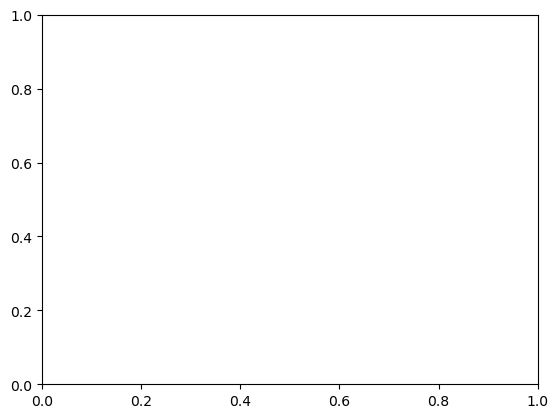

In [13]:
base_gini_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
base_gini_model.fit(x_train, y_train)
evaluate_model(base_gini_model, x_test, y_test)

In [ ]:
base_entropy_model = DecisionTreeClassifier(random_state=RANDOM_STATE , criterion='entropy')
base_entropy_model.fit(x_train, y_train)
evaluate_model(base_entropy_model, x_test, y_test)

#### Base Model  (Eliminating Gender Features (least significant))
From the mutual information gain we don't need these give minimal info.

In [ ]:
base_gini_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
base_gini_model.fit(x_train.loc[:, ~x_train.columns.isin(['Female', 'Male'])], y_train)
evaluate_model(base_gini_model, x_test.loc[:, ~x_test.columns.isin(['Female', 'Male'])], y_test)

The decission tree classifier on the reduced feature set (Excluding Age features performs the sam as model with full feature set) i.e these features do not give much insight to target variable.

#### Base Model  (Eliminating BMI + Height (Most significant))
From the mutual information gain these are most significant.

In [ ]:
base_gini_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
base_gini_model.fit(x_train.loc[:, ~x_train.columns.isin(['BMI', 'Weight'])], y_train)
evaluate_model(base_gini_model, x_test.loc[:, ~x_test.columns.isin(['BMI', 'Weight'])], y_test)

### Conclusion:

Summary of Findings:

Dataset Description: The dataset consists of information about individuals, including age, gender, height, weight, BMI, and a label indicating their weight category (e.g., "Normal Weight").

Exploratory Data Analysis (EDA): EDA revealed that the dataset contains a small sample size with only two individuals. Further analysis and model evaluation would benefit from a larger dataset.

Machine Learning Models: Three machine learning models—Logistic Regression, Random Forest, and Support Vector Machine (SVM)—were trained on the dataset.

Model Performance: The models were evaluated using accuracy, confusion matrices, and classification reports. Given the small dataset, the model performance metrics need to be interpreted with caution. The specific results will depend on the choice of model, hyperparameters, and dataset size.

